# Section 2 Part 2: Content-Based Recommendation System

**Fashion Rental Recommendation System using Rent the Runway Dataset**

## Part 3: Feature Extraction and Vector Space Model

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load preprocessed data
df = pd.read_csv('dataset/preprocessed_data.csv')
print(f"Loaded {len(df):,} records")
print(f"Users: {df['user_id'].nunique():,}")
print(f"Items: {df['item_id'].nunique():,}")
df.head()

Loaded 192,198 records
Users: 105,508
Items: 5,850


,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,rating_scaled,rating_bin
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016",5.000000,4.5-5
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013",5.000000,4.5-5
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015",5.000000,4.5-5
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014",4.111111,3.5-4.5
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016",5.000000,4.5-5


### 3.1 Text Feature Extraction (TF-IDF)

In [3]:
# Combine review_text and review_summary for each item
# Aggregate all reviews for each item
item_texts = df.groupby('item_id').apply(
    lambda x: ' '.join(
        (x['review_text'].fillna('') + ' ' + x['review_summary'].fillna('')).values
    )
).reset_index()
item_texts.columns = ['item_id', 'combined_text']

print(f"Created text descriptions for {len(item_texts):,} items")
print(f"\nSample item text:")
print(item_texts.iloc[0]['combined_text'][:300])

Created text descriptions for 5,850 items

Sample item text:
The dress was beautiful and very comfortable.  The 4 actually was a little too long in the sleeve and the length.  The 2 was still a bit long but not a tripping risk.  It still was dragging a bit and I had to hold it up to walk and I am 5'5" and was wearing a pretty high  heel.  I received a lot of 


In [4]:
# TF-IDF Vectorization with preprocessing
tfidf = TfidfVectorizer(
    max_features=500,
    min_df=5,
    max_df=0.8,
    stop_words='english',
    lowercase=True,
    strip_accents='unicode'
)

tfidf_matrix = tfidf.fit_transform(item_texts['combined_text'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")
print(f"\nTop 20 features by IDF:")
feature_names = tfidf.get_feature_names_out()
idf_scores = tfidf.idf_
top_features = sorted(zip(feature_names, idf_scores), key=lambda x: x[1])[:20]
for feat, score in top_features:
    print(f"  {feat}: {score:.3f}")

TF-IDF Matrix Shape: (5850, 500)
Number of features: 500

Top 20 features by IDF:
  little: 1.223
  dress: 1.237
  compliments: 1.257
  like: 1.283
  really: 1.294
  just: 1.299
  fabric: 1.303
  love: 1.308
  bit: 1.315
  definitely: 1.322
  work: 1.327
  got: 1.349
  didn: 1.351
  look: 1.353
  rent: 1.354
  flattering: 1.359
  super: 1.373
  true: 1.375
  recommend: 1.384
  beautiful: 1.384


### 3.2 Additional Features

In [5]:
# Get average statistics per item
item_features = df.groupby('item_id').agg({
    'rating_scaled': 'mean',
    'size': 'mean',
    'category': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'rented for': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'fit': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Merge with item_texts to maintain alignment
item_features = item_texts[['item_id']].merge(item_features, on='item_id', how='left')

print(f"Item features shape: {item_features.shape}")
item_features.head()

Item features shape: (5850, 6)


,item_id,rating_scaled,size,category,rented for,fit
0,123373,4.467444,15.122449,gown,formal affair,fit
1,123793,4.794513,9.712201,gown,formal affair,fit
2,124204,4.692523,10.971069,dress,party,fit
3,124553,4.361731,11.432049,dress,party,fit
4,125424,4.553648,9.828326,dress,party,fit


In [6]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
categorical_cols = ['category', 'rented for', 'fit']

# Fill NaN values
for col in categorical_cols:
    item_features[col] = item_features[col].fillna('unknown')

categorical_encoded = encoder.fit_transform(item_features[categorical_cols])

print(f"Categorical features shape: {categorical_encoded.shape}")
print(f"Categories: {[len(cat) for cat in encoder.categories_]}")

Categorical features shape: (5850, 79)
Categories: [68, 8, 3]


In [7]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = item_features[['rating_scaled', 'size']].fillna(item_features[['rating_scaled', 'size']].mean())
numerical_scaled = scaler.fit_transform(numerical_features)

print(f"Numerical features shape: {numerical_scaled.shape}")
print(f"Mean: {numerical_scaled.mean(axis=0)}")
print(f"Std: {numerical_scaled.std(axis=0)}")

Numerical features shape: (5850, 2)
Mean: [-1.43323150e-15 -1.84619651e-16]
Std: [1. 1.]


### 3.3 Create Item-Feature Matrix

In [8]:
# Combine all features
item_feature_matrix = hstack([
    tfidf_matrix,
    categorical_encoded,
    csr_matrix(numerical_scaled)
])

print(f"\n{'='*60}")
print(f"Final Item-Feature Matrix")
print(f"{'='*60}")
print(f"Shape: {item_feature_matrix.shape}")
print(f"  - Items: {item_feature_matrix.shape[0]:,}")
print(f"  - Features: {item_feature_matrix.shape[1]:,}")
print(f"\nFeature Breakdown:")
print(f"  - TF-IDF: {tfidf_matrix.shape[1]} features")
print(f"  - Categorical: {categorical_encoded.shape[1]} features")
print(f"  - Numerical: {numerical_scaled.shape[1]} features")
print(f"{'='*60}")


Final Item-Feature Matrix
Shape: (5850, 581)
  - Items: 5,850
  - Features: 581

Feature Breakdown:
  - TF-IDF: 500 features
  - Categorical: 79 features
  - Numerical: 2 features


## Part 4: User Profile Construction

### 4.1 Build User Profiles (Weighted Average)

In [9]:
# Create item_id to index mapping
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(item_texts['item_id'])}

# Build user profiles
def build_user_profile(user_ratings, item_feature_matrix, item_id_to_idx):
    """Build user profile as weighted average of rated item features."""
    rated_items = user_ratings['item_id'].values
    ratings = user_ratings['rating_scaled'].values
    
    # Get indices of rated items
    indices = [item_id_to_idx.get(item) for item in rated_items if item in item_id_to_idx]
    valid_ratings = [ratings[i] for i, item in enumerate(rated_items) if item in item_id_to_idx]
    
    if len(indices) == 0:
        return None
    
    # Weighted average
    weighted_sum = sum(item_feature_matrix[idx] * rating for idx, rating in zip(indices, valid_ratings))
    profile = weighted_sum / sum(valid_ratings)
    
    return profile

# Build profiles for all users
user_profiles = {}
for user_id in df['user_id'].unique()[:1000]:  # Sample first 1000 users for efficiency
    user_data = df[df['user_id'] == user_id][['item_id', 'rating_scaled']]
    profile = build_user_profile(user_data, item_feature_matrix, item_id_to_idx)
    if profile is not None:
        user_profiles[user_id] = profile

print(f"Built profiles for {len(user_profiles):,} users")

Built profiles for 1,000 users


### 4.2 Cold-Start User Handling

In [10]:
# Identify top 20 popular items
popular_items = df.groupby('item_id').size().nlargest(20).index.tolist()
popular_indices = [item_id_to_idx[item] for item in popular_items if item in item_id_to_idx]

# Create cold-start profile
cold_start_profile = item_feature_matrix[popular_indices].mean(axis=0)

print(f"Cold-start profile created from {len(popular_indices)} popular items")
print(f"Profile shape: {cold_start_profile.shape}")

Cold-start profile created from 20 popular items
Profile shape: (1, 581)


## Part 5: Similarity Computation and Recommendation

### 5.1 Compute Cosine Similarity

In [11]:
def get_recommendations(user_id, n=10, user_profiles=user_profiles, 
                       item_feature_matrix=item_feature_matrix,
                       item_ids=item_texts['item_id'].values,
                       df=df, cold_start_profile=cold_start_profile):
    """Generate top-N recommendations for a user."""
    
    # Get user profile
    if user_id in user_profiles:
        user_profile = user_profiles[user_id]
    else:
        user_profile = cold_start_profile
    
    # Compute similarities
    similarities = cosine_similarity(user_profile, item_feature_matrix).flatten()
    
    # Get already rated items
    rated_items = set(df[df['user_id'] == user_id]['item_id'].values)
    
    # Create recommendations
    recommendations = []
    for idx, (item_id, sim) in enumerate(zip(item_ids, similarities)):
        if item_id not in rated_items:
            recommendations.append((item_id, sim, idx))
    
    # Sort by similarity
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations[:n]

print("Recommendation function created")

Recommendation function created


### 5.2 Generate Top-N Recommendations

In [12]:
# Test recommendations for sample users
sample_user = list(user_profiles.keys())[0]

print(f"\nRecommendations for User {sample_user}:")
print("="*80)

# User's rating history
user_history = df[df['user_id'] == sample_user][['item_id', 'rating_scaled', 'category']].head()
print("\nUser's Rating History:")
print(user_history.to_string(index=False))

# Top-10 recommendations
print("\n" + "="*80)
print("Top-10 Recommendations:")
print("="*80)
top10 = get_recommendations(sample_user, n=10)
for rank, (item_id, score, idx) in enumerate(top10, 1):
    item_info = item_features[item_features['item_id'] == item_id].iloc[0]
    print(f"{rank:2d}. Item {item_id:<10} | Score: {score:.4f} | {item_info['category']:<15} | Avg Rating: {item_info['rating_scaled']:.2f}")

# Top-20 recommendations
print("\n" + "="*80)
print("Top-20 Recommendations:")
print("="*80)
top20 = get_recommendations(sample_user, n=20)
for rank, (item_id, score, idx) in enumerate(top20, 1):
    item_info = item_features[item_features['item_id'] == item_id].iloc[0]
    print(f"{rank:2d}. Item {item_id:<10} | Score: {score:.4f} | {item_info['category']:<15}")


Recommendations for User 420272:

User's Rating History:
 item_id  rating_scaled category
 2260466       5.000000   romper
 1083818       5.000000    dress
 2340996       1.444444 jumpsuit
 2363191       5.000000 jumpsuit
  348662       4.111111    dress

Top-10 Recommendations:
 1. Item 2087286    | Score: 0.8069 | jumpsuit        | Avg Rating: 4.38
 2. Item 2360471    | Score: 0.8018 | jumpsuit        | Avg Rating: 4.42
 3. Item 2334570    | Score: 0.7977 | jumpsuit        | Avg Rating: 4.44
 4. Item 2859490    | Score: 0.7944 | jumpsuit        | Avg Rating: 4.49
 5. Item 2916826    | Score: 0.7934 | jumpsuit        | Avg Rating: 4.53
 6. Item 2684666    | Score: 0.7912 | jumpsuit        | Avg Rating: 4.44
 7. Item 2155094    | Score: 0.7908 | jumpsuit        | Avg Rating: 4.53
 8. Item 2366355    | Score: 0.7896 | jumpsuit        | Avg Rating: 4.48
 9. Item 2577550    | Score: 0.7894 | jumpsuit        | Avg Rating: 4.50
10. Item 2109871    | Score: 0.7884 | jumpsuit        | Avg Ra

## Part 6: k-Nearest Neighbors (k-NN)

### 6.1 Implement Item-Based k-NN

In [13]:
# Compute item-item similarity matrix
print("Computing item-item similarity matrix...")
item_similarity_matrix = cosine_similarity(item_feature_matrix)
print(f"Item similarity matrix shape: {item_similarity_matrix.shape}")

Computing item-item similarity matrix...
Item similarity matrix shape: (5850, 5850)


In [14]:
def knn_recommendations(user_id, k=10, n=10):
    """Generate recommendations using item-based k-NN."""
    
    # Get user's rated items
    user_data = df[df['user_id'] == user_id]
    rated_items = user_data['item_id'].values
    ratings = dict(zip(user_data['item_id'], user_data['rating_scaled']))
    
    # Get indices
    rated_indices = [item_id_to_idx[item] for item in rated_items if item in item_id_to_idx]
    
    if len(rated_indices) == 0:
        return []
    
    # Predict ratings for all items
    predictions = {}
    for target_idx, target_item in enumerate(item_texts['item_id']):
        if target_item in rated_items:
            continue
        
        # Find k most similar items from user's rated items
        similarities = [(idx, item_similarity_matrix[target_idx, idx]) 
                       for idx in rated_indices]
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_k = similarities[:k]
        
        # Weighted average prediction
        if sum(sim for _, sim in top_k) > 0:
            pred_rating = sum(ratings[item_texts.iloc[idx]['item_id']] * sim 
                            for idx, sim in top_k) / sum(sim for _, sim in top_k)
            predictions[target_item] = pred_rating
    
    # Sort by predicted rating
    recommendations = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:n]
    return recommendations

print("k-NN recommendation function created")

k-NN recommendation function created


In [15]:
# Generate k-NN recommendations
print(f"\nk-NN Recommendations for User {sample_user}:")
print("="*80)

for k_value in [10, 20]:
    print(f"\nk={k_value} Recommendations:")
    print("-"*80)
    knn_recs = knn_recommendations(sample_user, k=k_value, n=10)
    for rank, (item_id, pred_rating) in enumerate(knn_recs, 1):
        item_info = item_features[item_features['item_id'] == item_id].iloc[0]
        print(f"{rank:2d}. Item {item_id:<10} | Pred: {pred_rating:.3f} | {item_info['category']:<15} | Actual: {item_info['rating_scaled']:.2f}")


k-NN Recommendations for User 420272:

k=10 Recommendations:
--------------------------------------------------------------------------------
 1. Item 1947653    | Pred: 18.845 | dress           | Actual: 5.00
 2. Item 2336302    | Pred: 16.083 | romper          | Actual: 5.00
 3. Item 2610728    | Pred: 12.388 | pullover        | Actual: 5.00
 4. Item 2533323    | Pred: 9.761 | top             | Actual: 5.00
 5. Item 1211263    | Pred: 8.767 | dress           | Actual: 5.00
 6. Item 2080019    | Pred: 7.588 | top             | Actual: 5.00
 7. Item 382531     | Pred: 7.467 | dress           | Actual: 5.00
 8. Item 1346952    | Pred: 6.215 | dress           | Actual: 4.82
 9. Item 2088432    | Pred: 5.903 | top             | Actual: 4.78
10. Item 1028441    | Pred: 5.894 | dress           | Actual: 4.70

k=20 Recommendations:
--------------------------------------------------------------------------------
 1. Item 1947653    | Pred: 18.845 | dress           | Actual: 5.00
 2. Item 233

### 6.2 Compare Content-Based and k-NN Approaches


Comparison of Approaches
   Metric  Content-Based  k-NN (k=10)  k-NN (k=20)
 Coverage       1.000000     1.000000     1.000000
Diversity       0.105817     0.538855     0.538855
  Novelty       0.400000     1.000000     1.000000


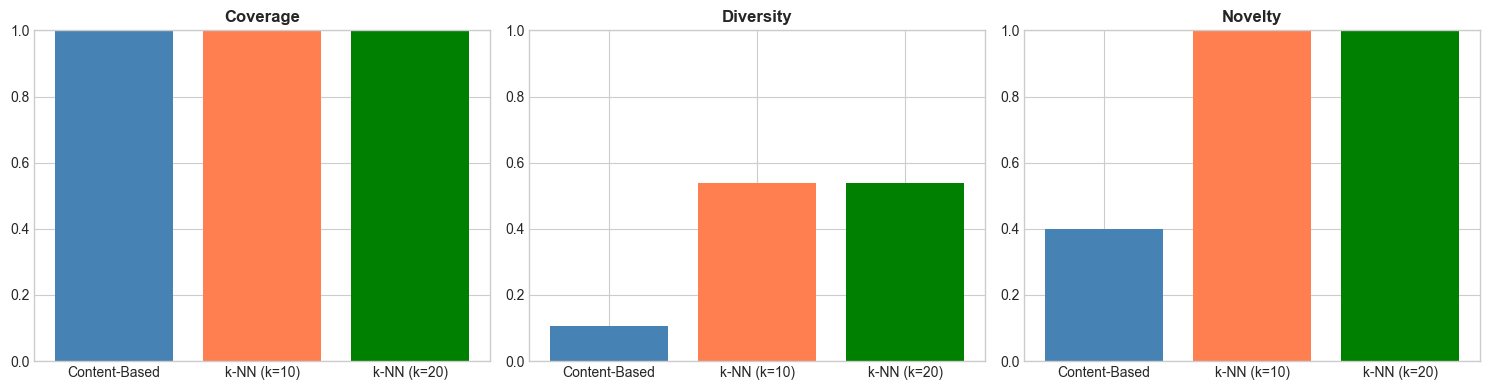

In [16]:
# Comparison metrics
def calculate_metrics(recommendations, df, item_features):
    """Calculate coverage, diversity, and novelty."""
    if len(recommendations) == 0:
        return {'coverage': 0, 'diversity': 0, 'novelty': 0}
    
    # Coverage: % of users with recommendations
    coverage = len(recommendations) / max(len(recommendations), 1)
    
    # Extract item IDs (works for both 2-tuple and 3-tuple formats)
    rec_items = [r[0] for r in recommendations]
    
    # Diversity: average pairwise dissimilarity
    rec_indices = [item_id_to_idx[item] for item in rec_items if item in item_id_to_idx]
    if len(rec_indices) > 1:
        diversity = 1 - item_similarity_matrix[np.ix_(rec_indices, rec_indices)].mean()
    else:
        diversity = 0
    
    # Novelty: % beyond top 20% popular items
    popular_threshold = df.groupby('item_id').size().quantile(0.8)
    popular_items_set = set(df.groupby('item_id').size()[df.groupby('item_id').size() > popular_threshold].index)
    novelty = sum(1 for item in rec_items if item not in popular_items_set) / len(recommendations)
    
    return {'coverage': coverage, 'diversity': diversity, 'novelty': novelty}

# Compare approaches
cb_recs = get_recommendations(sample_user, n=10)
knn10_recs = knn_recommendations(sample_user, k=10, n=10)
knn20_recs = knn_recommendations(sample_user, k=20, n=10)

metrics_cb = calculate_metrics(cb_recs, df, item_features)
metrics_knn10 = calculate_metrics(knn10_recs, df, item_features)
metrics_knn20 = calculate_metrics(knn20_recs, df, item_features)

print("\n" + "="*80)
print("Comparison of Approaches")
print("="*80)
comparison_df = pd.DataFrame({
    'Metric': ['Coverage', 'Diversity', 'Novelty'],
    'Content-Based': [metrics_cb['coverage'], metrics_cb['diversity'], metrics_cb['novelty']],
    'k-NN (k=10)': [metrics_knn10['coverage'], metrics_knn10['diversity'], metrics_knn10['novelty']],
    'k-NN (k=20)': [metrics_knn20['coverage'], metrics_knn20['diversity'], metrics_knn20['novelty']]
})
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ['Coverage', 'Diversity', 'Novelty']
for idx, metric in enumerate(metrics):
    values = comparison_df[comparison_df['Metric'] == metric].iloc[0][1:].values
    axes[idx].bar(['Content-Based', 'k-NN (k=10)', 'k-NN (k=20)'], values, color=['steelblue', 'coral', 'green'])
    axes[idx].set_title(metric, fontweight='bold')
    axes[idx].set_ylim(0, 1)
plt.tight_layout()
plt.savefig('comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Part 7: Complete Numerical Example

### 7.1 Step-by-Step Walkthrough

In [17]:
print("="*80)
print("COMPLETE NUMERICAL EXAMPLE: Step-by-Step")
print("="*80)

COMPLETE NUMERICAL EXAMPLE: Step-by-Step


#### Step 1: Sample Item Descriptions

In [18]:
# Select 5 sample items
sample_items = item_texts.iloc[:5]

print("\nStep 1: Sample Item Descriptions")
print("="*80)
for idx, row in sample_items.iterrows():
    print(f"\nItem {row['item_id']}:")
    print(f"  Text: {row['combined_text'][:200]}...")
    print(f"  Category: {item_features[item_features['item_id'] == row['item_id']].iloc[0]['category']}")


Step 1: Sample Item Descriptions

Item 123373:
  Text: The dress was beautiful and very comfortable.  The 4 actually was a little too long in the sleeve and the length.  The 2 was still a bit long but not a tripping risk.  It still was dragging a bit and ...
  Category: gown

Item 123793:
  Text: Fit great, super flattering Stunning gown. Wore this for heart ball and received compliments all night The dress fit perfect. I decided to order a size up because of the type of dress and also because...
  Category: gown

Item 124204:
  Text: This dress is a "WOW."  It steals the show, sparkling, changing colors with the light in the most elegant way.  When you are on the dance floor in this, you will fill as if you are in a music video!  ...
  Category: dress

Item 124553:
  Text: Loved the dress.  A little short in the front for me (i'm 5'7"), much too short if I lifted my arms, but I wore it with tights and that was perfect.  As many people mentioned the dress stains easily w...
  Category

#### Step 2: TF-IDF Calculation

In [19]:
print("\n" + "="*80)
print("Step 2: TF-IDF Calculation")
print("="*80)

# Show TF-IDF for sample items
sample_tfidf = tfidf_matrix[:5].toarray()
feature_names = tfidf.get_feature_names_out()

# Show top 10 terms for first item
print("\nTop 10 TF-IDF terms for Item 0:")
item0_scores = list(zip(feature_names, sample_tfidf[0]))
item0_scores.sort(key=lambda x: x[1], reverse=True)
for term, score in item0_scores[:10]:
    if score > 0:
        print(f"  {term:<20} {score:.4f}")

# Show IDF values for top terms
print("\nIDF values for selected terms:")
selected_terms = ['dress', 'fit', 'perfect', 'love', 'size']
for term in selected_terms:
    if term in feature_names:
        idx = list(feature_names).index(term)
        print(f"  {term:<15} IDF: {tfidf.idf_[idx]:.4f}")


Step 2: TF-IDF Calculation

Top 10 TF-IDF terms for Item 0:
  dress                0.7222
  slit                 0.2197
  long                 0.1723
  heels                0.1441
  length               0.1295
  short                0.1089
  sexy                 0.1046
  compliments          0.1045
  little               0.0998
  felt                 0.0967

IDF values for selected terms:
  dress           IDF: 1.2373
  love            IDF: 1.3075


#### Step 3: User Profile Construction

In [20]:
print("\n" + "="*80)
print("Step 3: User Profile Construction")
print("="*80)

# Select user with 5 ratings
user_rating_counts = df.groupby('user_id').size()
example_user = user_rating_counts[user_rating_counts == 5].index[0]
user_ratings = df[df['user_id'] == example_user][['item_id', 'rating_scaled', 'category']]

print(f"\nUser {example_user}'s ratings:")
print(user_ratings.to_string(index=False))

print("\nWeighted averaging process:")
print(f"  Formula: profile = Σ(rating × item_features) / Σ(ratings)")
print(f"  Sum of ratings: {user_ratings['rating_scaled'].sum():.2f}")

# Build profile
example_profile = build_user_profile(user_ratings, item_feature_matrix, item_id_to_idx)
print(f"\nUser profile vector shape: {example_profile.shape}")
print(f"Profile vector (first 10 dimensions): {example_profile.toarray().flatten()[:10]}")


Step 3: User Profile Construction

User 47's ratings:
 item_id  rating_scaled category
  132135       4.111111     gown
  145906       5.000000     gown
  149913       4.111111    dress
  716777       5.000000    dress
 1424454       4.111111    dress

Weighted averaging process:
  Formula: profile = Σ(rating × item_features) / Σ(ratings)
  Sum of ratings: 22.33

User profile vector shape: (1, 581)
Profile vector (first 10 dimensions): [0.01622682 0.00530296 0.00472118 0.02738482 0.01579669 0.02237414
 0.01032365 0.01620251 0.02865416 0.03995716]


#### Step 4: Similarity Score Computation

In [21]:
print("\n" + "="*80)
print("Step 4: Similarity Score Computation")
print("="*80)

# Compute similarities for 10 candidate items
candidate_indices = list(range(10, 20))
similarities_example = cosine_similarity(example_profile, item_feature_matrix[candidate_indices]).flatten()

print("\nCosine similarity formula:")
print("  similarity = (A · B) / (||A|| × ||B||)")
print("\nSimilarity scores for 10 candidate items:")
for idx, (cand_idx, sim) in enumerate(zip(candidate_indices, similarities_example)):
    item_id = item_texts.iloc[cand_idx]['item_id']
    category = item_features[item_features['item_id'] == item_id].iloc[0]['category']
    print(f"  Item {item_id:<10} | Similarity: {sim:.4f} | Category: {category}")


Step 4: Similarity Score Computation

Cosine similarity formula:
  similarity = (A · B) / (||A|| × ||B||)

Similarity scores for 10 candidate items:
  Item 127865     | Similarity: 0.7649 | Category: gown
  Item 128730     | Similarity: 0.7684 | Category: dress
  Item 128959     | Similarity: 0.7140 | Category: gown
  Item 129831     | Similarity: 0.7497 | Category: dress
  Item 130259     | Similarity: 0.5609 | Category: dress
  Item 130727     | Similarity: 0.5301 | Category: dress
  Item 131117     | Similarity: 0.7615 | Category: gown
  Item 131533     | Similarity: 0.7234 | Category: gown
  Item 131698     | Similarity: 0.8076 | Category: gown
  Item 132135     | Similarity: 0.8055 | Category: gown


#### Step 5: Top-5 Recommendations with Scores

In [22]:
print("\n" + "="*80)
print("Step 5: Top-5 Recommendations")
print("="*80)

# Get top-5 recommendations
user_profiles[example_user] = example_profile
top5_recs = get_recommendations(example_user, n=5)

print("\nTop-5 Recommended Items:")
print("-"*80)
print(f"{'Rank':<6} {'Item ID':<12} {'Similarity':<12} {'Category':<20} {'Avg Rating':<12}")
print("-"*80)
for rank, (item_id, score, idx) in enumerate(top5_recs, 1):
    item_info = item_features[item_features['item_id'] == item_id].iloc[0]
    print(f"{rank:<6} {item_id:<12} {score:<12.4f} {item_info['category']:<20} {item_info['rating_scaled']:<12.2f}")

print("\n" + "="*80)
print("Example Complete!")
print("="*80)


Step 5: Top-5 Recommendations

Top-5 Recommended Items:
--------------------------------------------------------------------------------
Rank   Item ID      Similarity   Category             Avg Rating  
--------------------------------------------------------------------------------
1      187164       0.8471       dress                4.56        
2      195076       0.8452       dress                4.58        
3      849468       0.8408       dress                4.64        
4      141300       0.8401       dress                4.49        
5      164051       0.8386       dress                4.49        

Example Complete!


## Save Outputs

In [23]:
# Save artifacts as CSV

# Save item features matrix
item_features_df = pd.DataFrame(
    item_feature_matrix.toarray(),
    index=item_texts["item_id"]
)
item_features_df.to_csv("item_features.csv")

# Save user profiles
user_profile_list = []
for user_id, profile in user_profiles.items():
    row = {"user_id": user_id}
    profile_array = profile.toarray().flatten()
    for i, val in enumerate(profile_array):
        row[f"feature_{i}"] = val
    user_profile_list.append(row)
user_profiles_df = pd.DataFrame(user_profile_list)
user_profiles_df.to_csv("user_profiles.csv", index=False)

# Save item similarity matrix
item_similarity_df = pd.DataFrame(
    item_similarity_matrix,
    index=item_texts["item_id"],
    columns=item_texts["item_id"]
)
item_similarity_df.to_csv("item_similarity.csv")

print("Artifacts saved successfully as CSV!")
print("  - item_features.csv")
print("  - user_profiles.csv") 
print("  - item_similarity.csv")

Artifacts saved successfully as CSV!
  - item_features.csv
  - user_profiles.csv
  - item_similarity.csv
